# Libraries

All imports

In [33]:
import numpy as np
import metrics
import cv2
from matplotlib import pyplot as plt
from skimage.filters.rank import threshold

import autoencoder
import visualization

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

# Load and prepare data
Importing and preprocessing of images into a image dataset

In [34]:
image_size = (152, 152)

normal_dir = "../dataset/AUTO_Input/train/"
anomaly_dir = "../dataset/AUTO_Input/test/"

normal_images = autoencoder.create_image_dataset(normal_dir, image_size)
anomaly_images = autoencoder.create_image_dataset(anomaly_dir, image_size)

Found 209 files.
Found 65 files.


# Build and compile autoencoder

In [35]:
#ae = autoencoder.build_and_compile(image_size)
#ae.summary()

# Create train test split

In [36]:
ae_normal_set, ml_normal_set = train_test_split(normal_images, test_size=0.2)
ae_anomaly_set, ml_anomaly_set = train_test_split(anomaly_images, test_size=0.2)

ae_train_set, ae_test_set = train_test_split(ae_normal_set, test_size=0.2)

# Train the model

In [37]:
#reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_delta=0.0005)
#early_stop = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.0002, restore_best_weights=True)
#callbacks = [reduce_lr, early_stop]

#history = autoencoder.fit_model(ae, ae_train_set, epochs=15, batch_size=32, callbacks=callbacks)

# Plot training loss and validation loss from history

In [38]:
#visualization.plot_metrics(history, accuracy=False)

# Import the model if trained in other file

In [39]:
ae = load_model("./model.keras")

# Predict on normal test data and anomalous data

In [40]:
normal_predictions = ae.predict(ae_test_set)
anomaly_predictions = ae.predict(anomaly_images)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step


# Visual comparison of original images and predicted image

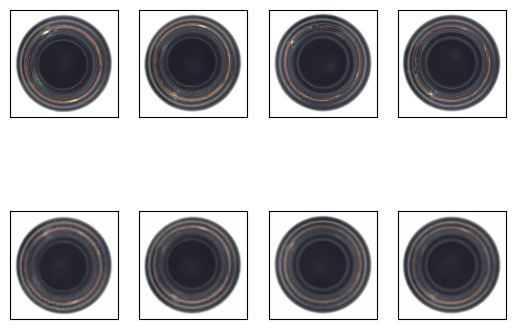

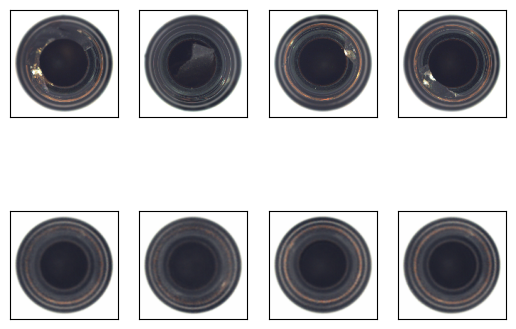

In [41]:
visualization.display_before_after(ae_test_set, normal_predictions)
visualization.display_before_after(anomaly_images, anomaly_predictions)

# Calculate similarity score and get image of difference

In [42]:
win_size = 9
gaussian_weights = False
threshold = 0.0

normal_scores, normal_masks = autoencoder.get_scores_and_masks(
    ae_test_set, 
    normal_predictions, 
    win_size=win_size, 
    gaussian_weights=gaussian_weights,
    threshold=threshold,
)

anomaly_scores, anomaly_masks = autoencoder.get_scores_and_masks(
    anomaly_images,
    anomaly_predictions,
    win_size=win_size,
    gaussian_weights=gaussian_weights,
    threshold=threshold,
)

# Plot images with mask image

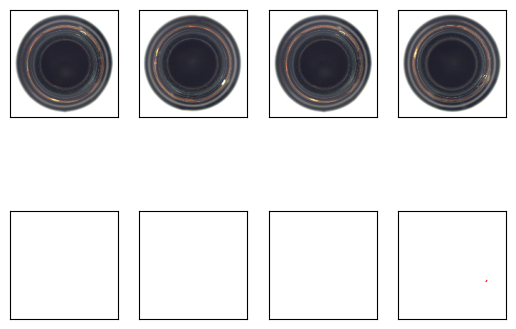

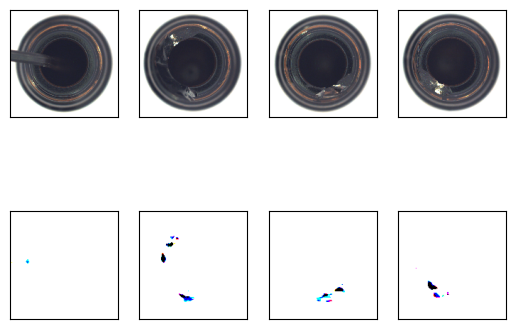

In [43]:
visualization.display_before_after(ae_test_set, normal_masks)
visualization.display_before_after(anomaly_images, anomaly_masks)

In [44]:
coords = cv2.findNonZero(anomaly_masks[0])
x,y,w,h = cv2.boundingRect(coords)
cv2.rectangle(anomaly_masks[0], (x,y), (x+w,y+h), (1.0,0.0,0.0), 2)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\count_non_zero.dispatch.cpp:156: error: (-215:Assertion failed) src.channels() == 1 && src.dims == 2 in function 'cv::findNonZero'


In [12]:
normal_count = len(normal_masks)
anomaly_count = len(anomaly_masks)

normal_sums = []
normal_psnr = []
normal_mse = []
anomaly_sums = []
anomaly_psnr = []
anomaly_mse = []
    
for i in range(normal_count):
    normal_sum = np.sum(normal_masks[i])
    temp_psnr = metrics.psnr(ae_test_set[i], normal_predictions[i])
    temp_mse = metrics.mse(ae_test_set[i], normal_predictions[i])
    
    normal_sums.append(normal_sum)
    normal_psnr.append(temp_psnr)
    normal_mse.append(temp_mse)
    
for i in range(anomaly_count):
    anomaly_sum = np.sum(anomaly_masks[i])
    temp_psnr = metrics.psnr(anomaly_images[i], anomaly_predictions[i])
    temp_mse = metrics.mse(anomaly_images, anomaly_predictions[i])
    
    anomaly_sums.append(anomaly_sum)
    anomaly_psnr.append(temp_psnr)
    anomaly_mse.append(temp_mse)
    
psnr_threshold = (min(normal_psnr) + max(anomaly_psnr)) / 2
mse_threshold = (max(normal_mse) + min(anomaly_mse)) / 2
scores_threshold = (min(normal_scores) + max(anomaly_scores)) / 2
sums_threshold = (min(normal_sums) + max(anomaly_sums)) / 2

In [16]:
wrong = 0
for i in range(anomaly_count):
    if anomaly_psnr[i] >= psnr_threshold and anomaly_mse[i] <= mse_threshold and anomaly_scores[i] >= scores_threshold and anomaly_sums[i] >= sums_threshold:
        wrong += 1
        
print(f"wrong anomaly predictions: {wrong}")
print(f"total anomaly predictions: {anomaly_count}")

wrong = 0
for i in range(normal_count):
    if normal_psnr[i] < psnr_threshold and normal_mse[i] > mse_threshold and normal_scores[i] < scores_threshold and normal_sums[i] < sums_threshold:
        wrong += 1
        
print(f"wrong normal predictions: {wrong}")
print(f"total normal predictions: {normal_count}")

wrong = 0
for i in range(anomaly_count):
    if anomaly_mse[i] < mse_threshold:
        wrong += 1
        
print(f"wrong anomaly predictions from mse: {wrong}")
print(f"total anomaly predictions: {normal_count}")

print(f"max normal mse: {max(normal_mse)}")
print(f"min normal mse: {min(normal_mse)}")
print(f"max anomaly mse: {max(anomaly_mse)}")
print(f"min anomaly mse: {min(anomaly_mse)}")

wrong anomaly predictions: 0
total anomaly predictions: 780
wrong normal predictions: 0
total normal predictions: 402
wrong anomaly predictions from mse: 0
total anomaly predictions: 402
max normal mse: 0.0017116988310590386
min normal mse: 0.0008023492991924286
max anomaly mse: 0.009737944230437279
min anomaly mse: 0.005309155210852623
